## Roost comparison for Figure 3

Here we compare the MAE values from the Roost learning curves to our MAE.
We reproduce the MAE reported here: 

Predicting materials properties without crystal structure: deep representation learning from stoichiometry
Rhys E. A. Goodall & Alpha A. Lee 
Nature communications

To retrieve the csv files follow the zenodo link under data availability, and they are in the directory `results`. At time of writing this link is at https://doi.org/10.5281/zenodo.4133793

This data is also used to calculate the MAE for the set of oxides we consider for FEFOS, which went in to create Figure 3.

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter


In [2]:
# These csv files are ordered to match how we will plot them from left to right
# on the learning curve, so the first csv file here was trained with the 
# least number of training points, the last one trained with the largest
# number of training points
csvs_in_order = [
'roost_test_data/ensemble_results_oqmd-ef_s-0_t-501.csv',
'roost_test_data/ensemble_results_oqmd-ef_s-0_t-230.csv',
'roost_test_data/ensemble_results_oqmd-ef_s-0_t-105.csv',
'roost_test_data/ensemble_results_oqmd-ef_s-0_t-48.csv',
'roost_test_data/ensemble_results_oqmd-ef_s-0_t-22.csv',
'roost_test_data/ensemble_results_oqmd-ef_s-0_t-10.csv',
'roost_test_data/ensemble_results_oqmd-ef_s-0_t-4.csv',
'roost_test_data/ensemble_results_oqmd-ef_s-0_t-2.csv',
'roost_test_data/ensemble_results_oqmd-ef_s-0_t-1.csv',
]


In [3]:
def calculate_errors(oxide_condition, csvs):
    """
    This function calculates the errors for a set of oxides which are conditioned on
    the basis of a string which is used to condition over the id column
    provided from the Nature Communications paper learning curves
    Args:
    oxide_condition: A string representing the ratio of oxygen we want to measure the
    mean absolute errors for, must be of the form '0.600', i.e. it has to have this length
    with 5 characters, and be a string.
    """
    total_maes = []
    oxide_maes = []
    csvfiles = []
    for csv in csvs:
        df = pd.read_csv(csv)
        csvfiles.append(csv)
        # the csv files have different separators for the title row across the csvs 
        sep = ''
        try:
            dummy_val = df['pred_0'][0]
            sep = '_'
        except:
            dummy_val = df['pred-0'][0]
            sep = '-'
        if sep=='_':
            ensemble = df[['pred_0', 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5', 'pred_6', 'pred_7', 'pred_8', 'pred_9']].mean(axis=1)
            one_err = df['pred_0']
        elif sep=='-':
            ensemble = df[['pred-0', 'pred-1', 'pred-2', 'pred-3', 'pred-4', 'pred-5', 'pred-6', 'pred-7', 'pred-8', 'pred-9']].mean(axis=1)
            one_err = df['pred-0']

        #print("MAE ROOST all: {:.4f}".format(np.mean(abs(df['target']-ensemble))))
        total_maes.append(np.mean(abs(df['target']-ensemble)))
        count = 0
        one_vals = []
        targets = []
        ensembles = []
        for df_index, comp in enumerate(df['composition']):
            num_elements = 0
            oxide_match = False
            for idx, c in enumerate(comp):
                if c.isupper():
                    num_elements+=1
                    if c=='O' and comp[idx+1]=='0' and comp[idx+1:idx+6]==oxide_condition:
                        # is binary oxide with matching composition as oxide_condition 
                        oxide_match = True
            if num_elements==3 and oxide_match:
                count+=1
                target = df.loc[df_index]['target']
                targets.append(df.loc[df_index]['target'])
                if sep=='-':
                    val = df.loc[df_index]['pred-0']
                    one_vals.append(val)
                    pred_sum = 0 
                    for i in range(0, 10):
                        pred_sum+=df.loc[df_index]['pred-{}'.format(i)]
                    ensembles.append(0.1*pred_sum) 
                elif sep=='_':
                    val = df.loc[df_index]['pred_0']
                    one_vals.append(val)
                    pred_sum = 0 
                    for i in range(0, 10):
                        pred_sum+=df.loc[df_index]['pred_{}'.format(i)]
                    ensembles.append(0.1*pred_sum) 
        num_oxides = count
        oxide_maes.append(np.mean(abs(np.array(targets)-np.array(ensembles))))
        #print("MAE conditioned on oxides: {:.4f}\n".format(np.mean(abs(np.array(targets)-np.array(ensembles)))))
    print("Number of oxides: {}".format(num_oxides))
    return total_maes, oxide_maes, csvs, num_oxides


In [4]:
print("MO oxides")
roost_err1, mo_err, csv_files1, num_mo = calculate_errors("0.500", csvs_in_order)
print("M2O3 oxides")
roost_err2, m2o3_err, csv_files2, num_m2o3 = calculate_errors("0.600", csvs_in_order)
print("MO2 oxides")
roost_err3, mo2_err, csv_files3, num_mo2 = calculate_errors("0.666", csvs_in_order)

# sanity check
assert roost_err1==roost_err2==roost_err3
assert csv_files1==csv_files2==csv_files3

total_oxides = num_mo+num_m2o3+num_mo2
total_oxide_error = [(mo*num_mo+m2o3*num_m2o3+mo2*num_mo2)*(1.0/(total_oxides)) for mo, m2o3, mo2 in zip(mo_err, m2o3_err, mo2_err)]
roost_err = roost_err1

MO oxides
Number of oxides: 44
M2O3 oxides
Number of oxides: 285
MO2 oxides
Number of oxides: 49


## Plot learning curves

Text(0.5, 0, 'Number of training points')

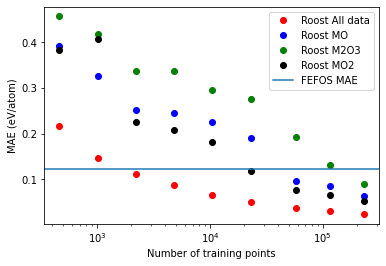

In [5]:
# taking values reported in the Nature Comm
# https://www.nature.com/articles/s41467-020-19964-7
training_points = [
    461, 1005, 2200, 4812, 10499, 23096, 57740, 115480, 230959
]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(training_points, roost_err, 'ro', label='Roost All data')
plt.plot(training_points, mo_err, 'bo', label='Roost MO')
plt.plot(training_points, m2o3_err, 'go', label='Roost M2O3')
plt.plot(training_points, mo2_err, 'ko', label='Roost MO2')
ax.set_xscale('log')

plt.axhline(0.123, label='FEFOS MAE')
plt.legend()
plt.ylabel("MAE (eV/atom)")
plt.xlabel("Number of training points")


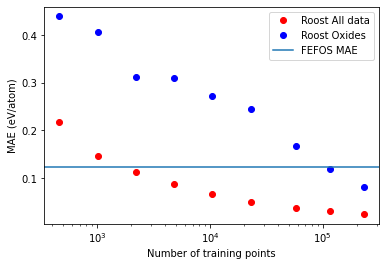

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(training_points, roost_err, 'ro', label='Roost All data')
plt.plot(training_points, total_oxide_error, 'bo', label='Roost Oxides')
# plt.plot(training_points, m2o3_err, 'go', label='Roost M2O3')
# plt.plot(training_points, mo2_err, 'ko', label='Roost MO2')
ax.set_xscale('log')

plt.axhline(0.123, label='FEFOS MAE')
plt.legend()
plt.ylabel("MAE (eV/atom)")
plt.xlabel("Number of training points")
plt.savefig("roost_compare_all.pdf")